In [1]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import json
import gensim
from IPython.core.display import display, HTML

In [2]:
truncated_enron_df = pd.read_csv('enron_test.csv')
truncated_enron_df.From = [list(eval(item))[0] for item in truncated_enron_df.From]
truncated_enron_df.To =[list(eval(item))[0] if not pd.isnull(item) else item for item in truncated_enron_df.To]
clean_truncated_enron_df = truncated_enron_df.dropna(subset=['To'])

#### Create Email Network Visualization using D3

In [3]:
# Aggregate emails by sender and receipient 
# Create unique emali list based on the aggregated result
grouped_enron_df = clean_truncated_enron_df.groupby(['From', 'To']).agg({'content': 'count'}).reset_index()
unique_emails = pd.Index(np.unique(list(grouped_enron_df.From) + list(grouped_enron_df.To)))

In [4]:
grouped_enron_df.head()

,From,To,content
0,1.11913372.-2@multexinvestornetwork.com,pallen@enron.com,1
1,alyse.herasimchuk@enron.com,stuart.staley@enron.com,1
2,announce@inbox.nytimes.com,pallen@ect.enron.com,2
3,aod@newsdata.com,western.price.survey.contacts@proxy4.ba.best.com,1
4,aod@newsdata.com,western.price.survey.contacts@ren-6.cais.net,1


In [7]:
# Create Links List
temp_link_list = list(grouped_enron_df.apply(lambda row: {'source': row['From'], 'target': row['To'], 'value': row['content']}, axis = 1))
links_list = []
for link in temp_link_list:
    record = {'value': link['value'], 
              'source':unique_emails.get_loc(link['source']), 
              'target':unique_emails.get_loc(link['target'])}
    links_list.append(record)

In [8]:
# Create Nodes List
nodes_list = []
for email in unique_emails:
    nodes_list.append({'name':email, 'group':unique_emails.get_loc(email)})

In [9]:
# Combine Links List and Nodes List and save them into a json file
json_prep = {'nodes':nodes_list, 'links':links_list}
json_dump = json.dumps(json_prep, indent=1, sort_keys=True)
filename = "email_network.json"
json_out = open(filename, 'w')
json_out.write(json_dump)
json_out.close()

In [10]:
# D3 visualization code
js_text = '''
<!-- python -m SimpleHTTPServer 8080 //-->
<!-- http://bl.ocks.org/mbostock/4062045 //-->

<!DOCTYPE html>
<head>
<meta charset="utf-8">
<title>Enron Email Network Analysis</title>

<!-- JavaScript Libraries //-->
<script src="http://d3js.org/d3.v3.min.js"></script>

<!-- CSS Style //-->
<link href="http://fonts.googleapis.com/css?family=Source+Sans+Pro:300,900|Source+Code+Pro:300" rel="stylesheet" type="text/css">
<style>
body {
    font-family: 'Source Sans Pro', sans-serif;
    font-weight: 300;
}

b {
    font-weight: 900;
}

.outline {
    fill: none;
    stroke: #888888;
    stroke-width: 1px;
}

#tooltip {
    font-size: 10pt;
    font-weight: 900;

    fill: #000000;
    stroke: #ffffff;
    stroke-width: 0.25px;
}

.node {
    stroke: #ffffff;
    stroke-weight: 1px;
}

.link {
    fill: none;
    stroke: #888888;
    stroke-weight: 1px;
    stroke-opacity: 0.5;
}

.highlight {
    stroke: red;
    stroke-weight: 4px;
    stroke-opacity: 1.0;
}
</style>

<script>
var width  = 1200;
var height = 900;
var margin = 20;
var pad = margin / 2;
var color = d3.scale.category20();
// Generates a tooltip for a SVG circle element based on its ID
function addTooltip(circle) {
    var x = parseFloat(circle.attr("cx"));
    var y = parseFloat(circle.attr("cy"));
    var r = parseFloat(circle.attr("r"));
    var text = circle.attr("id");
    var tooltip = d3.select("#plot")
        .append("text")
        .text(text)
        .attr("x", x)
        .attr("y", y)
        .attr("dy", -r * 2)
        .attr("id", "tooltip");
    var offset = tooltip.node().getBBox().width / 2;
    if ((x - offset) < 0) {
        tooltip.attr("text-anchor", "start");
        tooltip.attr("dx", -r);
    }
    else if ((x + offset) > (width - margin)) {
        tooltip.attr("text-anchor", "end");
        tooltip.attr("dx", r);
    }
    else {
        tooltip.attr("text-anchor", "middle");
        tooltip.attr("dx", 0);
    }
}
var vis = d3.select("#chart")
  .append("svg:svg")
    .attr("width", width)
    .attr("height", height)
    .attr("pointer-events", "all")
  .append('svg:g')
    .call(d3.behavior.zoom().on("zoom", redraw))
  .append('svg:g');
vis.append('svg:rect')
    .attr('width', width)
    .attr('height', height)
    .attr('fill', 'white');
function redraw() {
  console.log("here", d3.event.translate, d3.event.scale);
  vis.attr("transform",
      "translate(" + d3.event.translate + ")"
      + " scale(" + d3.event.scale + ")");
}
function drawGraph(graph) {
    var svg = d3.select("#force").append("svg")
        .attr("width", width)
        .attr("height", height);
    // draw plot background
    svg.append("rect")
        .attr("width", width)
        .attr("height", height)
        .style("fill", "#eeeeee");
    // create an area within svg for plotting graph
    var plot = svg.append("g")
        .attr("id", "plot")
        .attr("transform", "translate(" + pad + ", " + pad + ")");
    // https://github.com/mbostock/d3/wiki/Force-Layout#wiki-force
    var layout = d3.layout.force()
        .size([width - margin, height - margin])
        .charge(-80)
        .linkDistance(function(d, i) {
            return (d.source.group == d.target.group) ? 50 : 100;
        })
        .nodes(graph.nodes)
        .links(graph.links)
        .start();
    drawLinks(graph.links);
    drawNodes(graph.nodes);
    // add ability to drag and update layout
    // https://github.com/mbostock/d3/wiki/Force-Layout#wiki-drag
    d3.selectAll(".node").call(layout.drag);
    // https://github.com/mbostock/d3/wiki/Force-Layout#wiki-on
    layout.on("tick", function() {
        d3.selectAll(".link")
            .attr("x1", function(d) { return d.source.x; })
            .attr("y1", function(d) { return d.source.y; })
            .attr("x2", function(d) { return d.target.x; })
            .attr("y2", function(d) { return d.target.y; });
        d3.selectAll(".node")
            .attr("cx", function(d) { return d.x; })
            .attr("cy", function(d) { return d.y; });
    });
}
    function tick(e) {
  // Push different nodes in different directions for clustering.
  var k = 6 * e.alpha;
  graph.nodes.forEach(function(o, i) {
    o.y += i & 1 ? k : -k;
    o.x += i & 2 ? k : -k;
  });
  node.attr("cx", function(d) { return d.x; })
      .attr("cy", function(d) { return d.y; });
}
// Draws nodes on plot
function drawNodes(nodes) {
    // used to assign nodes color by group
    var color = d3.scale.category20();
    // https://github.com/mbostock/d3/wiki/Force-Layout#wiki-nodes
    d3.select("#plot").selectAll(".node")
        .data(nodes)
        .enter()
        .append("circle")
        .attr("class", "node")
        .attr("id", function(d, i) { return d.name; })
        .attr("cx", function(d, i) { return d.x; })
        .attr("cy", function(d, i) { return d.y; })
        .attr("r",  function(d, i) { return 4; })
        .style("fill",   function(d, i) { return color(d.group); })
        .on("mouseover", function(d, i) { addTooltip(d3.select(this)); })
        .on("mouseout",  function(d, i) { d3.select("#tooltip").remove(); });
}
// Draws edges between nodes
function drawLinks(links) {
    var scale = d3.scale.linear()
        .domain(d3.extent(links, function(d, i) {
           return d.value;
        }))
        .range([1, 6]);
    // https://github.com/mbostock/d3/wiki/Force-Layout#wiki-links
    d3.select("#plot").selectAll(".link")
        .data(links)
        .enter()
        .append("line")
        .attr("class", "link")
        .attr("x1", function(d) { return d.source.x; })
        .attr("y1", function(d) { return d.source.y; })
        .attr("x2", function(d) { return d.target.x; })
        .attr("y2", function(d) { return d.target.y; })
        .style("stroke-width", function(d, i) {
            return scale(d.value) + "px";
        })
        .style("stroke-dasharray", function(d, i) {
            return (d.value <= 1) ? "2, 2" : "none";
        });
}
</script>
</head>

<body>
<div align="center" id="force"></div>

<script>
d3.json("email_network.json", drawGraph);
</script>
</body>
</html>
'''

In [11]:
## Embed the d3 visualization result into the jupyter notebook
HTML(js_text)

#### Insights
1. Phillip Allen is the "center of the universe" within this email dataset. He involved with most of the emails and had connections to almost all the people occured in the data records.

2. There are some other small network clusters that are not related with Phillip Allen. For example: a cluster with Pallen as the center. But the numbers of the people in those clusters are significantly lower then the "Phillip Allen" cluster.

3. There are not many loops in this email network. We may infer that there might be certain email communication policy in Enron where people have to send email to a main point of contact rather than to a stakeholder directly. 

#### Centrality Analysis

Definition: 
    In graph theory and network analysis, indicators of centrality identify the most important vertices within a graph. 

In [23]:
G = nx.from_pandas_edgelist(truncated_enron_df, 'From', 'To', edge_attr=['new_date', 'Subject'])

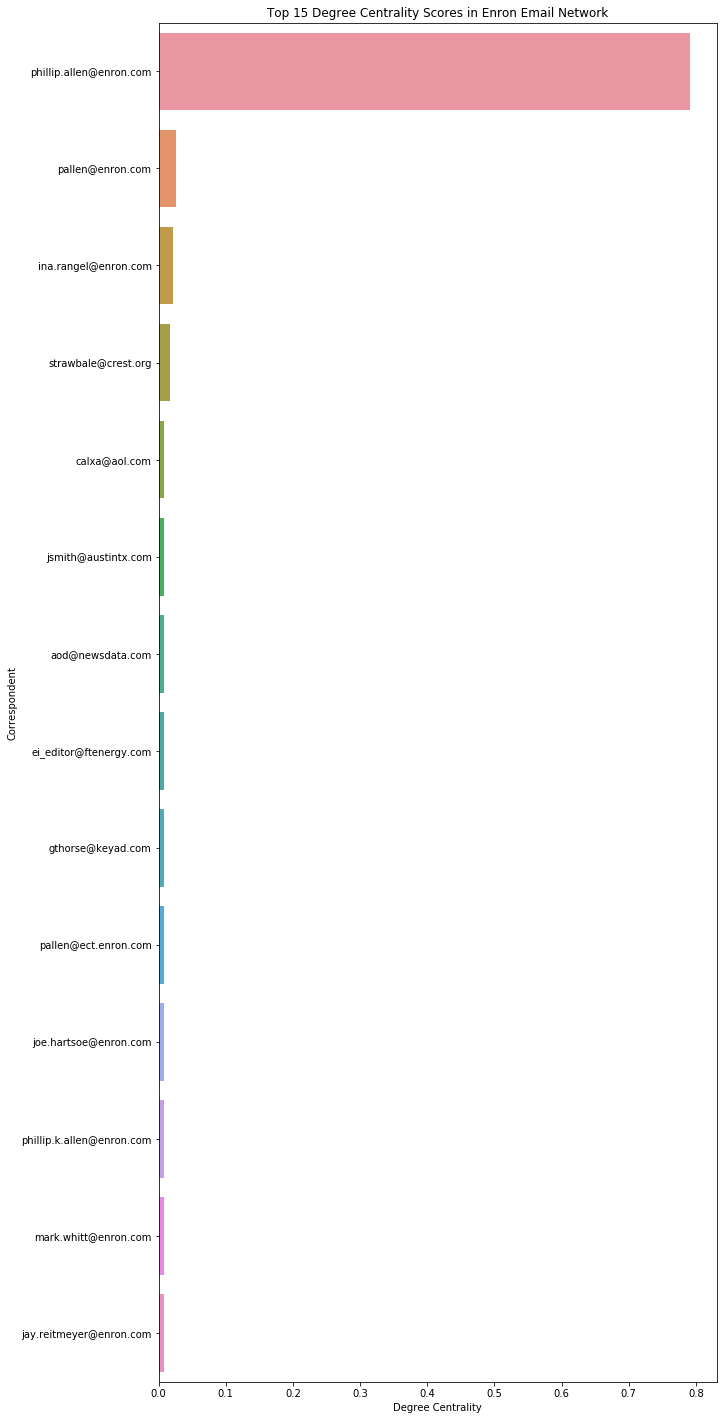

In [38]:
cent = nx.degree_centrality(G)
name = []
centrality = []

for key, value in cent.items():
    name.append(key)
    centrality.append(value)

cent = pd.DataFrame()    
cent['name'] = name
cent['centrality'] = centrality
cent = cent.sort_values(by='centrality', ascending=False)

plt.figure(figsize=(10, 25))
_ = sns.barplot(x='centrality', y='name', data=cent[:15], orient='h')
_ = plt.xlabel('Degree Centrality')
_ = plt.ylabel('Correspondent')
_ = plt.title('Top 15 Degree Centrality Scores in Enron Email Network')
plt.show()

#### Insights
1. The result of Centrality analysis is well aligned with our observations based on the graph visualization in previous section. We noticed Philip Allen who plays a predominant role in the network also has the largest centrality. The second largest cluster's center (Pallen) is also the one with second largest centrality.
2. This doesn't necessarily mean the centrality analysis here is redundant. For a more general and complex network, this analysis can help people quickly indentify the most important nodes in the network using a quantitative method.